In [1]:
!pip install --upgrade -q fastai
!pip install timm -q
!pip install albumentations==0.4.6 -q
!pip install transformers -q

In [2]:
from fastai.vision.all import *
import timm
import warnings 
import albumentations as A
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings('ignore')
set_seed(21, reproducible=True)

In [58]:
test=[]
id_=[]
diir="../input/animal-classification-challenge/test/test/"
for i in os.listdir(diir):
    id_.append(i)
    path=diir+i
    test.append(path)

In [59]:
test

['../input/animal-classification-challenge/test/test/ASG00188s4_1.jpeg',
 '../input/animal-classification-challenge/test/test/ASG001d2yx_0.jpeg',
 '../input/animal-classification-challenge/test/test/ASG00184rr_1.jpeg',
 '../input/animal-classification-challenge/test/test/ASG0019o8t_2.jpeg',
 '../input/animal-classification-challenge/test/test/ASG001epek_1.jpeg',
 '../input/animal-classification-challenge/test/test/ASG001e78r_2.jpeg',
 '../input/animal-classification-challenge/test/test/ASG00177nc_1.jpeg',
 '../input/animal-classification-challenge/test/test/ASG001ehbs_1.jpeg',
 '../input/animal-classification-challenge/test/test/ASG001e100_0.jpeg',
 '../input/animal-classification-challenge/test/test/ASG001e1d7_1.jpeg',
 '../input/animal-classification-challenge/test/test/ASG001ekjr_2.jpeg',
 '../input/animal-classification-challenge/test/test/ASG0016vdo_2.jpeg',
 '../input/animal-classification-challenge/test/test/ASG0016u5s_0.jpeg',
 '../input/animal-classification-challenge/test/tes

In [60]:
train_zebra=[]
diiir="../input/animal-classification-challenge/train_zebras/train_zebras/"
for i in os.listdir(diiir):
    path=diiir+i
    train_zebra.append(path)

In [61]:
train_ele=[]
dr="../input/animal-classification-challenge/train_elephants/train_elephants/"
for i in os.listdir(dr):
    path=dr+i
    train_ele.append(path)

In [62]:
z=[0 for i in range(len(train_zebra))]
e=[1 for i in range(len(train_ele))]
L=train_ele+train_zebra
l=e+z
train=pd.DataFrame({"image_path":L,"Label":l})

In [63]:
train

,image_path,Label
0,../input/animal-classification-challenge/train_elephants/train_elephants/ASG001fzgr_0.jpeg,1
1,../input/animal-classification-challenge/train_elephants/train_elephants/ASG00167km_0.jpeg,1
2,../input/animal-classification-challenge/train_elephants/train_elephants/ASG001g2rq_0.jpeg,1
3,../input/animal-classification-challenge/train_elephants/train_elephants/ASG001b7at_2.jpeg,1
4,../input/animal-classification-challenge/train_elephants/train_elephants/ASG001clpy_1.jpeg,1
...,...,...
13994,../input/animal-classification-challenge/train_zebras/train_zebras/ASG001era1_0.jpeg,0
13995,../input/animal-classification-challenge/train_zebras/train_zebras/ASG001ekv6_1.jpeg,0
13996,../input/animal-classification-challenge/train_zebras/train_zebras/ASG001er36_2.jpeg,0
13997,../input/animal-classification-challenge/train_zebras/train_zebras/ASG001ekcq_2.jpeg,0


In [64]:
L[0]

'../input/animal-classification-challenge/train_elephants/train_elephants/ASG001fzgr_0.jpeg'

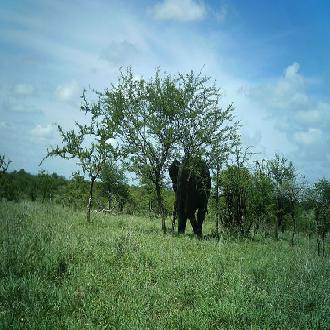

In [66]:
from PIL import Image
Image.open(train_ele[5000])

In [67]:
test=pd.DataFrame({"image_path":test})

In [68]:
train

,image_path,Label
0,../input/animal-classification-challenge/train_elephants/train_elephants/ASG001fzgr_0.jpeg,1
1,../input/animal-classification-challenge/train_elephants/train_elephants/ASG00167km_0.jpeg,1
2,../input/animal-classification-challenge/train_elephants/train_elephants/ASG001g2rq_0.jpeg,1
3,../input/animal-classification-challenge/train_elephants/train_elephants/ASG001b7at_2.jpeg,1
4,../input/animal-classification-challenge/train_elephants/train_elephants/ASG001clpy_1.jpeg,1
...,...,...
13994,../input/animal-classification-challenge/train_zebras/train_zebras/ASG001era1_0.jpeg,0
13995,../input/animal-classification-challenge/train_zebras/train_zebras/ASG001ekv6_1.jpeg,0
13996,../input/animal-classification-challenge/train_zebras/train_zebras/ASG001er36_2.jpeg,0
13997,../input/animal-classification-challenge/train_zebras/train_zebras/ASG001ekcq_2.jpeg,0


In [69]:
IMG_HEIGHT = IMG_WIDTH = 330
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)
INCEPTION_MEAN = INCEPTION_STD = (0.5, 0.5, 0.5)


class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx, order = None, 2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        
        return aug_img


def get_train_transforms(mean_std):
    augmentations = [
        A.HorizontalFlip(p=.5),
        A.VerticalFlip(p=.5),
        A.RandomRotate90(p=.5),
        A.ImageCompression(quality_lower=99, quality_upper=100),
        A.ShiftScaleRotate(
            shift_limit=0.2, scale_limit=0.2, 
            rotate_limit=45, border_mode=0, p=.5
        ),
        A.Resize(IMG_HEIGHT, IMG_WIDTH),
        A.Cutout(
            max_h_size=int(IMG_HEIGHT*0.4),
            max_w_size=int(IMG_WIDTH*0.4),
            num_holes=1,
            p=.75,
        ),
    ]
    if mean_std=='imagenet':
        augmentations.append(A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD))
    elif mean_std=='inception':
        augmentations.append(A.Normalize(mean=INCEPTION_MEAN, std=INCEPTION_STD))
    else:
        augmentations.append(A.Normalize(mean=0, std=1))

    augmentations.append(ToTensorV2())
    return A.Compose(augmentations)


def get_valid_transforms(mean_std):
    augmentations = [A.Resize(IMG_HEIGHT, IMG_WIDTH)]
    if mean_std=='imagenet':
        augmentations.append(A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD))
    elif mean_std=='inception':
        augmentations.append(A.Normalize(mean=INCEPTION_MEAN, std=INCEPTION_STD))
    else:
        augmentations.append(A.Normalize(mean=0, std=1))

    augmentations.append(ToTensorV2())
    return A.Compose(augmentations)

def get_item_tfms(mean_std='imagenet'):
    return [AlbumentationsTransform(get_train_transforms(mean_std), get_valid_transforms(mean_std))]

In [70]:
Train = train.copy()
Test = test.copy()


Train = Train[['image_path', 'Label']]
Test = Test[['image_path']]


skf = StratifiedKFold(10, shuffle=True, random_state=21)
X = Train.drop(columns='Label')
y = Train.Label

for fold, (_, valid_index) in enumerate(skf.split(X, y)):
  Train.loc[valid_index, "fold"] = fold

Train.fold = Train.fold.astype(int)

Train.head(2)

,image_path,Label,fold
0,../input/animal-classification-challenge/train_elephants/train_elephants/ASG001fzgr_0.jpeg,1,2
1,../input/animal-classification-challenge/train_elephants/train_elephants/ASG00167km_0.jpeg,1,5


In [71]:
class Head(nn.Module):
    def __init__(self, in_features, out_features):
        super(Head, self).__init__()
        self.head = nn.Linear(in_features=in_features, out_features=out_features)

    def forward(self, x):
        return self.head(x)


class Net(nn.Module):
    def __init__(
        self,
        base_model="resnet50",
        pretrained=True,
        checkpoint_path=None,
        num_classes=2,
    ):
        super(Net, self).__init__()

        self.backbone = timm.create_model(
            base_model, pretrained=pretrained, checkpoint_path=checkpoint_path
        )
        in_features = self.backbone.get_classifier().in_features
        self.backbone.reset_classifier(num_classes=0, global_pool="avg")
        self.neck = Head(in_features=in_features, out_features=in_features)
        self.head = Head(in_features=in_features, out_features=num_classes)

    def forward(self, x):
        x = self.backbone(x)
        x = self.neck(x)
        x = self.head(x)
        x = F.log_softmax(x, dim=1)
        return x

In [72]:
import gc
import inspect
from fastai.metrics import accuracy
from fastai.optimizer import OptimWrapper
from torch import optim
from functools import partial
from transformers import AdamW


def free_memory(to_delete: list):
    calling_namespace = inspect.currentframe().f_back

    for _var in to_delete:
        calling_namespace.f_locals.pop(_var, None)
        gc.collect()
        torch.cuda.empty_cache()

def get_dls(fold=0, mean_std='imagenet'):
    clas_block = DataBlock(blocks=(ImageBlock, CategoryBlock),
                        splitter=MaskSplitter(Train.fold == fold),
                        get_x=ColReader("image_path"),
                        get_y=ColReader("Label"),
                        item_tfms=get_item_tfms(mean_std),
                        )
    dls = clas_block.dataloaders(Train, bs=32)
    dls.rng.seed(21)

    return dls

In [ ]:
predictions = []
for fold in [1]:
    print('*'*25+f"Fold {fold}"+'*'*25)
    m_name = f'fold-{fold}'
    dls = get_dls(fold, 'imagenet')
    learn = Learner(dls, Net(base_model='convnext_tiny'), 
                    loss_func=CrossEntropyLossFlat(), metrics=accuracy,
                    opt_func=partial(OptimWrapper, opt=optim.Adam), 
                    cbs=[SaveModelCallback(reset_on_fit=False, fname=m_name)]
            )
    
    learn.fit_one_cycle(20, 2e-4)
    learn.save(m_name+'_stage-1')
    learn = learn.load(m_name)
    learn.freeze_to(-5)
    learn.fit_one_cycle(4, 2e-4)
    learn.save(m_name+'_stage-2');


    model = learn.load(m_name)
    preds, _ = model.tta(dl=dls.test_dl(Test), n=4)
    predictions.append(preds)

    free_memory([model, learn, preds, dls])

*************************Fold 1*************************


Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny_1k_224_ema.pth


epoch,train_loss,valid_loss,accuracy,time


In [ ]:
import numpy as np
pred = np.mean([i.numpy() for j, i in enumerate(predictions[-1:])], axis=0)

In [ ]:
submission=pd.DataFrame({"id":id_,"label":pred})
submission.to_csv("subb.csv", index=False)